In [2]:
# Import libraries
import pandas as pd
import numpy as np
import math

!pip install cplex
import cplex
import matplotlib.pyplot as plt


[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: pip install --upgrade pip


### Buy and Hold Strategy

In [3]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

### Equally Weighted Strategy

In [4]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    # Calculate the portfolio value
    p = np.dot(cur_prices, x_init) + cash_init
    # Set the number of stock euqal to 20 
    num = 20
    # Weight Equal
    w = np.ones((20)) / num
    # Equally allocate the wealth value for each stock
    value_each_stock = w * p
    # Calculate corresponding shares for each stock 
    x_optimal = np.floor(value_each_stock / cur_prices)
    # Find the transcation cost 
    cost = np.dot(cur_prices , abs(x_optimal - x_init)) * 0.005
    # Find how much cash we left in the portfilio
    cash_optimal = p - np.dot(cur_prices, x_optimal) - cost
    return x_optimal, cash_optimal

### Minimum Variance Strategy

In [5]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    # Calculate the portfolio value
    p = np.dot(cur_prices,x_init) + cash_init
    # Set the number of stock euqal to 20
    num = 20
    # Create the CPLEX object
    cpx = cplex.Cplex()
    # Set minimizer since we want to minimize the variance
    cpx.objective.set_sense(cpx.objective.sense.minimize) 
    c  = [0.0] * num
    lb = [0.0] * num
    ub = [1.0] * num
    lst = []
    for i in range(num):
        lst.append([[0,1],[1,0]])
    # Add objective function, bounds on variables and constraints to CPLEX model where sum of all weights equal to one
    cpx.linear_constraints.add(rhs = [1.0,0], senses = 'EG')
    cpx.variables.add(obj = c, lb = lb, ub = ub, columns = lst, names = ['w%s'% i for i in range(1, num + 1)])
    # Define and add quadratic part of objective function
    qmat = [[list(range(num)), list(2 * Q[k,:])] for k in range(num)] 
    cpx.objective.set_quadratic(qmat)
    # Set CPLEX parameters concurrent
    alg = cpx.parameters.lpmethod.values  
    cpx.parameters.qpmethod.set(alg.concurrent) 
    # Disable results output
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None) 
    cpx.solve()
    # Display minimum variance portfolio
    min_weight = np.array(cpx.solution.get_values())
    # Allocate the wealth value for each stock BY minimazing the variance
    value_each_stock = min_weight * p
    # Calculate corresponding shares for each stock 
    x_optimal = np.floor(value_each_stock / cur_prices)
    # Find the transcation cost 
    cost = np.dot(cur_prices , abs(x_optimal - x_init)) * 0.005
    # Find how much cash we left in the portfilio
    cash_optimal = p - np.dot(cur_prices, x_optimal) - cost
    return x_optimal, cash_optimal

### Maximum Sharpe Ratio Strategy

In [6]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    # Calculate the portfolio value
    p = cur_prices.dot(x_init) + cash_init
    # Set the number of stock equals to 21
    num = 21
    # Annual risk-free rate for yeas 2020 - 2021 is 2.5%
    r_rf = 0.025  
    # Calculate the daily risk-free rate (252 trading days)
    daily_rf = 0.025 / 252
    # Add new column and new row for risk-free asset
    Q1 = np.append(Q,np.zeros((20,1)), axis = 1)
    Q2 = np.vstack([Q1,np.zeros((21))]) 
    # Calculate the difference in mu_i and r_rf
    d = mu-daily_rf * np.ones(20) 
    lst = []
    for i in range(num - 1):
        lst.append([[0,1],[d[i],1.0]])
    lst.append([[0,1],[0,-1.0]]) 
    # Create the CPLEX object
    cpx = cplex.Cplex()
    # Set minimizer since we want to minimize the variance
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c = [0] * num
    lb = [0] * num
    ub = [np.inf] * num
    var_names = ['y%s'% i for i in range(1, num + 1)]
    # Add objective function
    cpx.linear_constraints.add(rhs = [1.0,0],senses = 'EE')
    cpx.variables.add(obj = c, lb = lb, ub = ub, columns = lst, names = var_names)
    # Define and add quadratic part of objective function
    qmat = [[list(range(num)),list(2*Q2[k,:])] for k in range(num)]
    cpx.objective.set_quadratic(qmat)
    # Set cplex parameters
    alg = cpx.parameters.lpmethod.values  
    cpx.parameters.qpmethod.set(alg.concurrent) 
    # Disable results output
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None) 
    cpx.solve()
    # Show the result
    result = np.array(cpx.solution.get_values())
    maxsharp_weight = result[0:20]/result[20]
    # Allocate the wealth value for each stock BY minimazing the variance
    value_each_stock = maxsharp_weight * p  
    # Calculate corresponding shares for each stock  
    x_optimal = np.floor(value_each_stock / cur_prices) 
    # Find the transcation cost 
    cost = np.dot(cur_prices , abs(x_optimal - x_init)) * 0.005
    cash_optimal = p - np.dot(cur_prices,x_optimal) - cost
    return x_optimal, cash_optimal

In [7]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
        
      if cash[strategy, period-1] < 0:
          ###calculating the portfolio value
          port_value = np.dot(cur_prices,curr_positions) + curr_cash
          ratio = x[strategy, period-1]/sum(x[strategy, period-1])
          cash_neg = abs(cash[strategy, period-1])*ratio
          position_neg = np.ceil(cash_neg/cur_prices)
          x[strategy, period-1] = x[strategy, period-1] - position_neg
          tran_cost_new = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
          curr_val = np.dot(cur_prices,x[strategy, period-1])
          cash[strategy, period-1] = port_value - curr_val - tran_cost_new

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Initial portfolio value = $ 1000012.93


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.03, value end = $ 893204.97
  Strategy "Mininum Variance Portfolio", value begin = $ 992742.20, value end = $ 916349.58
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.17, value end = $ 922092.60

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931389.80, value end = $ 862330.69
  Strategy "Mininum Variance Portfolio", value begin = $ 956110.62, value end = $ 851538.63
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 962076.86, value end = $ 1017235.47

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Buy and Hold", value begin = $ 937916.81, value end = $ 913415.30
 

In [8]:
# Plot results
###################### Insert your code here ############################


Plot one chart in Python that illustrates the daily value of your portfolio (for each
trading strategy) over the years 2020 and 2021 using daily prices provided. Include the
chart in your report.

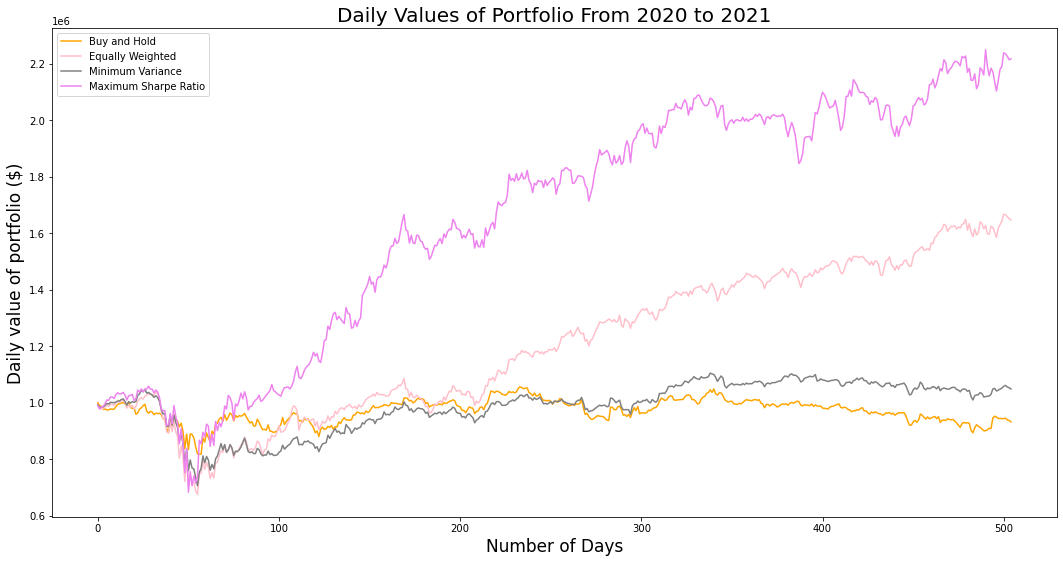

In [23]:
plt.figure(figsize = (18, 9))

plt.plot(portf_value[0], label = 'Buy and Hold', color = 'orange')
plt.plot(portf_value[1], label = 'Equally Weighted', color = 'pink')
plt.plot(portf_value[2], label = 'Minimum Variance', color = 'grey')
plt.plot(portf_value[3], label = 'Maximum Sharpe Ratio', color = 'violet')

plt.title('Daily Values of Portfolio From 2020 to 2021', fontsize = 20)
plt.xlabel('Number of Days', fontsize = 17)
plt.ylabel('Daily value of portfolio ($)', fontsize = 17)
plt.legend()
plt.show()

Plot two charts in Python for strategy 3 and 4 to show dynamic changes in portfolio
allocations. In each chart, x-axis represents the rolling up time horizon, y-axis denotes
portfolio weights between 0 and 1, and distinct lines display the position of selected assets
over time periods. You may use these figures to support your analysis or discussion.

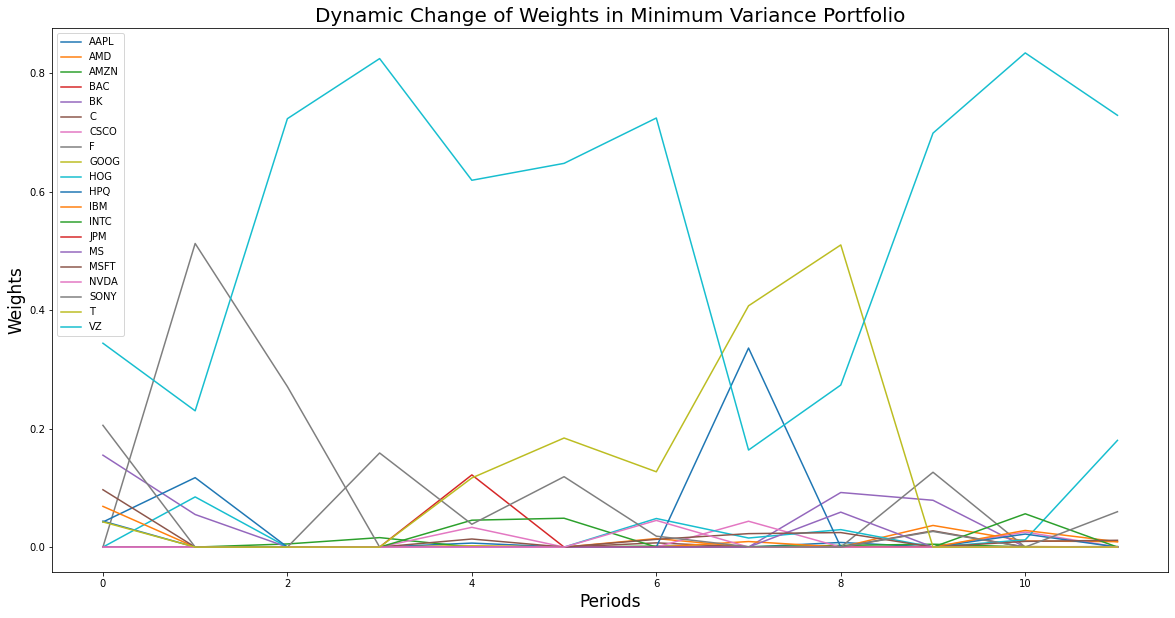

In [31]:
# Find stock name
stocks = df.columns[1:]
# Create the dynamic changes in portfolio allocations
total_period = N_periods + 1
lst = []
for period in range(1, total_period):
    sum_mv_share = sum(x[2, period - 1])
    weight_period = x[2, period - 1]/sum_mv_share
    lst.append(weight_period)
# Plot the graph
df_mv = pd.DataFrame(np.array(lst), columns = stocks)
df_mv.plot(figsize = (20, 10))
plt.title('Dynamic Change of Weights in Minimum Variance Portfolio', fontsize = 20)
plt.xlabel('Periods', fontsize = 17)
plt.ylabel('Weights', fontsize = 17)
plt.show()

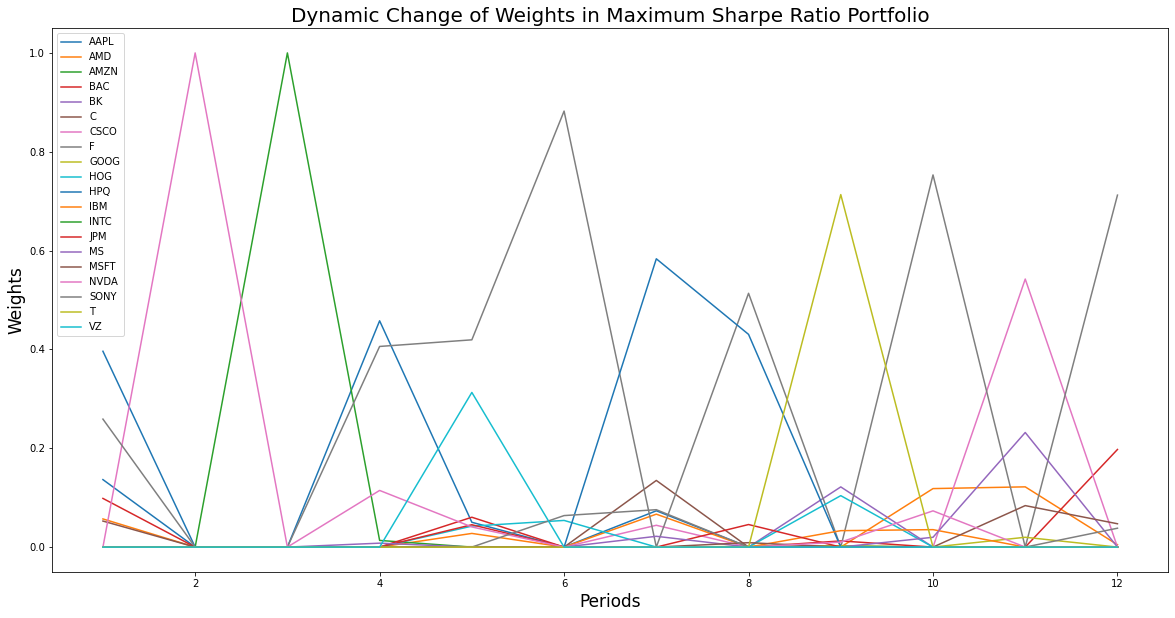

In [32]:
# Find stock name
stocks = df.columns[1:]
# Create the dynamic changes in portfolio allocations
total_period = N_periods + 1
lst = []
for period in range(1, total_period):
    sum_ms_share = sum(x[3, period - 1])
    weight_period = x[3, period-1]/sum_ms_share
    lst.append(weight_period)
# Plot the graph 
df_ms = pd.DataFrame(np.array(lst), columns = stocks, index = [1,2,3,4,5,6,7,8,9,10,11,12])
df_ms.plot(figsize = (20,10))
plt.title('Dynamic Change of Weights in Maximum Sharpe Ratio Portfolio', fontsize = 20)
plt.xlabel('Periods', fontsize = 17)
plt.ylabel('Weights', fontsize = 17)
plt.show()

Test your Python program for different variations of your strategies, e.g., select “1/n”
portfolio at the beginning of period 1 and hold it till the end of period 12 (as if the re-
balancing strategy required large transaction costs). Discuss if you are able to achieve
better results.

In [34]:
portfolio_V = 1000012.93 
#equal weight for the 20 stocks
w = np.ones((20)) / 20   
cur_prices = data_prices[0,:] 
#equal allocation of money for each asset 
each_asset_V = w * portfolio_V 
#rounding procedure of number of shares 
x_optimal = np.floor(each_asset_V / cur_prices)  
print(x_optimal)

[ 675. 1018.   26. 1468. 1041.  659. 1097. 5425.   36. 1389. 2560.  426.
  864.  378. 1013.  317.  835.  724. 1507.  904.]


In [40]:
def strat_buy_and_hold_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    x_init = np.array(x_init)
    portfolio_V = np.dot(cur_prices,x_init) + cash_init
    x_optimal = [ 675., 1018.,   26., 1468., 1041.,  659., 1097., 5425.,   36.,
       1389., 2560.,  426.,  864.,  378., 1013.,  317.,  835.,  724.,
       1507.,  904.]
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = portfolio_V - np.dot(cur_prices,x_optimal) - tran_cost
    return np.array(x_optimal), cash_optimal

In [41]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_buy_and_hold_equally_weighted']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Buy and Hold Equally Weighted']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_buy_and_hold_equally_weighted]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      while cash[strategy, period-1] < 0:
            
            portfolio_V = np.dot(cur_prices, curr_positions) + curr_cash
            ratio = x[strategy][period-1]/np.sum(x[strategy][period-1])
            neg_cash = abs(cash[strategy][period-1])*ratio
            neg_position = np.ceil(neg_cash/cur_prices)
            x[strategy][period-1] = x[strategy][period-1] - neg_position
            new_tran_cost = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
            cash[strategy, period-1] = portfolio_V - np.dot(cur_prices,x[strategy, period-1]) - new_tran_cost
            
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 1000012.93


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.03, value end = $ 893204.97
  Strategy "Mininum Variance Portfolio", value begin = $ 992742.20, value end = $ 916349.58
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.17, value end = $ 922092.60
  Strategy "Buy and Hold Equally Weighted", value begin = $ 990898.03, value end = $ 893204.97

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931389.80, value end = $ 862330.69
  Strategy "Mininum Variance Portfolio", value begin = $ 956110.62, value end = $ 851538.63
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 962076.86, value end = $ 1017235.47
  Strategy "Buy and Hold Equally Weigh

Plot one chart in Python that illustrates the daily value of your portfolio (for each trading strategy) over the years 2020 and 2021 using daily prices provided. Include the chart in your report.

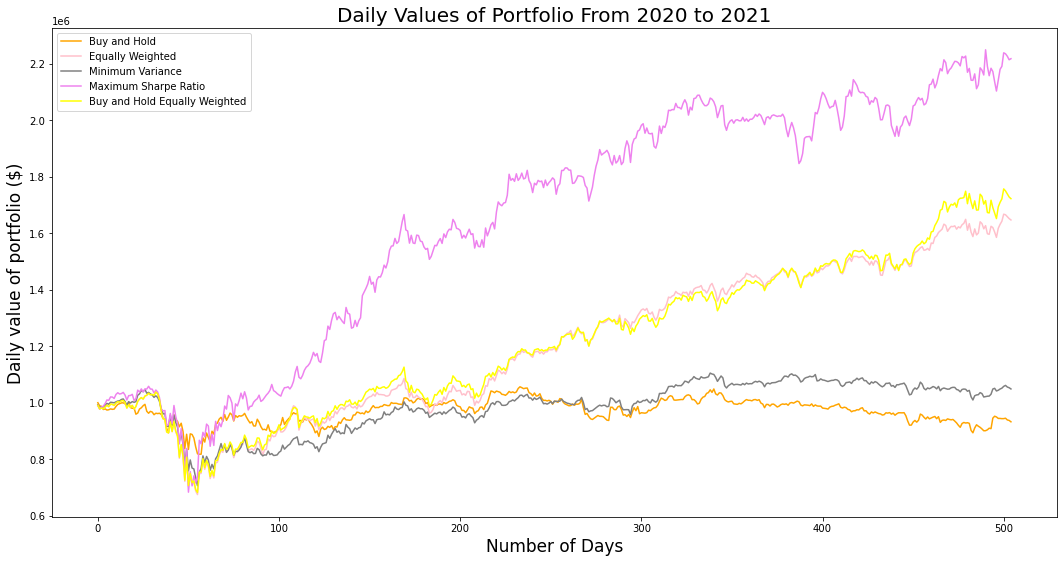

In [43]:
plt.figure(figsize = (18, 9))

plt.plot(portf_value[0], label = 'Buy and Hold', color = 'orange')
plt.plot(portf_value[1], label = 'Equally Weighted', color = 'pink')
plt.plot(portf_value[2], label = 'Minimum Variance', color = 'grey')
plt.plot(portf_value[3], label = 'Maximum Sharpe Ratio', color = 'violet')
plt.plot(portf_value[4], label = 'Buy and Hold Equally Weighted', color = 'yellow')

plt.title('Daily Values of Portfolio From 2020 to 2021', fontsize = 20)
plt.xlabel('Number of Days', fontsize = 17)
plt.ylabel('Daily value of portfolio ($)', fontsize = 17)
plt.legend()
plt.show()